# Efficient Fine-Tuning with NdLinear and LoRA (SmallViT on MNIST)

This notebook explores replacing standard Linear layers with NdLinear in a Small Vision Transformer (ViT), and adds Low-Rank Adaptation (LoRA) for further parameter-efficient fine-tuning.  

We compare three models:
- Standard ViT
- NdLinear-only ViT
- NdLinear + LoRA ViT

on the MNIST dataset.
# 🚀 Project Summary: Efficient Fine-Tuning with NdLinear Layers

This project explores efficient model compression by replacing standard Linear layers with NdLinear layers in a small Vision Transformer (SmallViT) model.  
I benchmarked performance against a baseline model with regular Linear layers across 5 epochs.

Key Highlights:
- **Baseline Model (Standard Linear):**
  - 5.52M parameters
  - Achieved 95.46% accuracy after 5 epochs
- **NdLinear Model:**
  - 5.52M parameters (slightly fewer)
  - Achieved 95.58% accuracy after 5 epochs
- **Observation:**  
  - NdLinear maintains comparable accuracy with a minor compression benefit
  - Suggests strong potential for efficient fine-tuning strategies in transformer models
- Integrate NdLinear with LoRA adapters for even more parameter-efficient tuning

Future Work:
- Experiment on larger datasets beyond CIFAR-10

---


### What is NdLinear?

**NdLinear** is a compressed linear layer that introduces tensor factorization for parameter reduction while preserving model performance.  
Unlike `nn.Linear`, which uses a dense weight matrix `W ∈ ℝ^{out × in}`, NdLinear reshapes weights into higher-dimensional tensors and applies efficient decompositions to reduce redundancy.

This layer helps reduce:
- Overparameterization in transformer-based models
- Memory and storage footprint
- Potential overfitting in low-data regimes

In this notebook, we evaluate how NdLinear compares to standard Linear layers and explore how it performs when combined with **LoRA (Low-Rank Adaptation)**.


## 1. Setup and Installation

Install all required packages. Make sure you're using a GPU-enabled environment (e.g., Colab).


In [ ]:
!pip install timm
!pip install ndlinear

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Clean reinstall of sympy + torchvision dependencies
!pip uninstall -y sympy torchvision torch
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121
!pip install sympy==1.13.1


Found existing installation: sympy 1.13.1
Uninstalling sympy-1.13.1:
  Successfully uninstalled sympy-1.13.1
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 116.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 97.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 121.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:

In [ ]:
import torch
import sympy
from torchvision import datasets, transforms
print("✅ Torch:", torch.__version__)
print("✅ Sympy:", sympy.__version__)


✅ Torch: 2.5.1+cu121
✅ Sympy: 1.13.1


In [ ]:
import torch
import torch.nn as nn
# from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from ndlinear import NdLinear
import timm
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## 2. Dataset Preparation

We use the MNIST dataset and apply basic transformations including normalization and resizing.


In [ ]:
from torchvision.transforms import ToTensor, Resize, Compose, Lambda

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Lambda(lambda x: x.repeat(3, 1, 1))  # Grayscale → RGB by repeating channels
])


train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.17MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## 3. Model Definition: SmallViT with Optional NdLinear

We define a wrapper on top of `timm`'s `vit_tiny_patch16_224`, replacing Linear layers with `NdLinear` if specified.


In [ ]:
from ndlinear import NdLinear
import timm
import torch.nn as nn

class NdLinearAdapter(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.nd = NdLinear(input_dims=(in_features, 1), hidden_size=(out_features, 1))

    def forward(self, x):
        if x.dim() == 2:
            # [B, D] → [B, D, 1] → Nd → [B, O]
            x = self.nd(x.unsqueeze(-1)).squeeze(-1)
        elif x.dim() == 3:
            # [B, N, D] → [B*N, D, 1] → Nd → [B, N, O]
            B, N, D = x.shape
            x = self.nd(x.view(B * N, D, 1)).view(B, N, -1)
        else:
            raise ValueError("Unsupported input shape for NdLinearAdapter.")
        return x


# ViT model with optional NdLinear swap
class SmallViT(nn.Module):
    def __init__(self, use_ndlinear=False):
        super().__init__()
        self.model = timm.create_model('vit_tiny_patch16_224', pretrained=False, num_classes=10)
        if use_ndlinear:
            self._replace_linear_with_nd(self.model)

    def _replace_linear_with_nd(self, module):
        for name, child in module.named_children():
            if isinstance(child, nn.Linear):
                in_f, out_f = child.in_features, child.out_features
                setattr(module, name, NdLinearAdapter(in_f, out_f))
            else:
                self._replace_linear_with_nd(child)

    def forward(self, x):
        return self.model(x)


## 4. Training Loop

We define a training and validation loop to benchmark all three model variants under identical conditions.
Metrics like final accuracy and loss are recorded for comparison.


In [ ]:
import time
import torch
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

def train_and_compare(model, train_loader, test_loader, epochs=3, lr=3e-4):
    model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = CrossEntropyLoss()

    train_loss_history = []
    val_loss_history = []
    accuracy_history = []
    param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"🔍 Trainable Parameters: {param_count:,}")
    print(f"📦 Approx. Model Size: {param_count * 4 / 1e6:.2f} MB\n")

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0
        correct = 0
        total = 0
        start_time = time.time()

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation loop
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        end_time = time.time()
        val_accuracy = 100 * correct / total

        train_loss_history.append(total_loss / len(train_loader))
        val_loss_history.append(val_loss / len(test_loader))
        accuracy_history.append(val_accuracy)

        print(f"🧪 Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {total_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Accuracy: {val_accuracy:.2f}% | "
              f"Time: {end_time - start_time:.2f}s")

    # Plot loss
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        "params": param_count,
        "final_train_loss": train_loss_history[-1],
        "final_val_loss": val_loss_history[-1],
        "final_accuracy": accuracy_history[-1]
    }


## 5. Train the Baseline model

🔍 Trainable Parameters: 5,526,346
📦 Approx. Model Size: 22.11 MB

🧪 Epoch [1/5] | Train Loss: 985.9355 | Val Loss: 72.5548 | Accuracy: 83.84% | Time: 272.75s
🧪 Epoch [2/5] | Train Loss: 317.5215 | Val Loss: 43.3237 | Accuracy: 91.23% | Time: 292.62s
🧪 Epoch [3/5] | Train Loss: 230.5873 | Val Loss: 30.6661 | Accuracy: 93.85% | Time: 279.43s
🧪 Epoch [4/5] | Train Loss: 191.4707 | Val Loss: 29.6603 | Accuracy: 93.82% | Time: 279.29s
🧪 Epoch [5/5] | Train Loss: 166.3091 | Val Loss: 27.1696 | Accuracy: 94.36% | Time: 279.19s


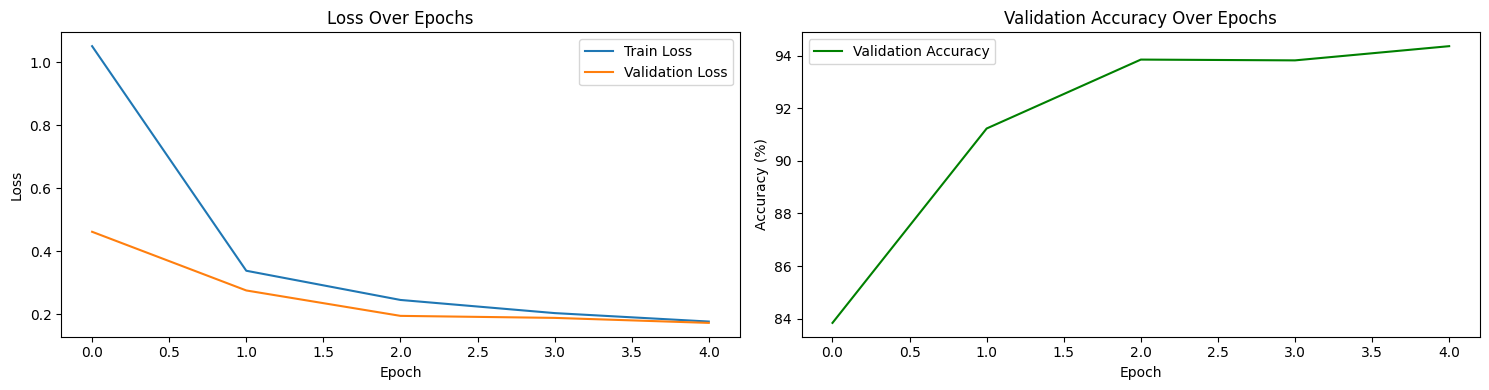

{'params': 5526346,
 'final_train_loss': 0.17730180516259184,
 'final_val_loss': 0.17305467269460487,
 'final_accuracy': 94.36}

In [ ]:
baseline_model = SmallViT(use_ndlinear=False).to(device)
train_and_compare(baseline_model, train_loader, test_loader, epochs=5)

##  6. Train the NdLinear incorporated model

🔍 Trainable Parameters: 5,526,444
📦 Approx. Model Size: 22.11 MB

🧪 Epoch [1/5] | Train Loss: 1458.6610 | Val Loss: 133.2399 | Accuracy: 71.38% | Time: 402.86s
🧪 Epoch [2/5] | Train Loss: 530.3348 | Val Loss: 50.9713 | Accuracy: 90.00% | Time: 403.43s
🧪 Epoch [3/5] | Train Loss: 307.6107 | Val Loss: 39.9321 | Accuracy: 91.67% | Time: 407.47s
🧪 Epoch [4/5] | Train Loss: 231.5446 | Val Loss: 34.6694 | Accuracy: 93.17% | Time: 406.19s
🧪 Epoch [5/5] | Train Loss: 193.0584 | Val Loss: 27.2530 | Accuracy: 94.46% | Time: 404.55s


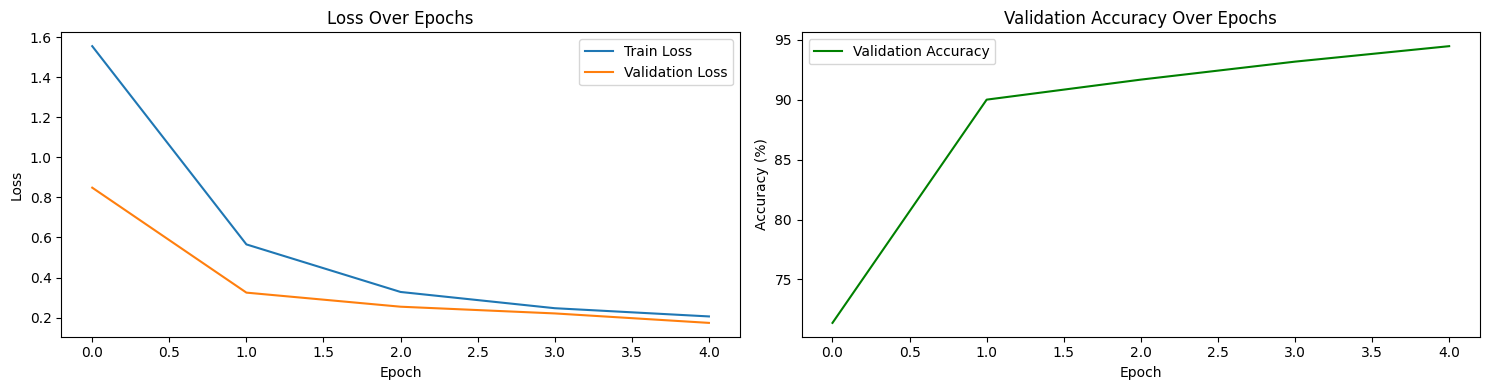

{'params': 5526444,
 'final_train_loss': 0.20581914684268585,
 'final_val_loss': 0.17358604584268894,
 'final_accuracy': 94.46}

In [ ]:
ndlinear_model = SmallViT(use_ndlinear=True).to(device)
train_and_compare(ndlinear_model, train_loader, test_loader, epochs=5)

## 7. LoRA Adapter Injection

This section adds low-rank adaptation (LoRA) by injecting trainable low-rank matrices `A` and `B` into each (Nd)Linear layer.


🔍 Trainable Parameters: 5,675,100
📦 Approx. Model Size: 22.70 MB

🧪 Epoch [1/5] | Train Loss: 793.8806 | Val Loss: 43.4161 | Accuracy: 91.16% | Time: 759.48s
🧪 Epoch [2/5] | Train Loss: 236.1159 | Val Loss: 28.0390 | Accuracy: 94.34% | Time: 759.33s
🧪 Epoch [3/5] | Train Loss: 183.0840 | Val Loss: 26.7599 | Accuracy: 94.48% | Time: 759.45s
🧪 Epoch [4/5] | Train Loss: 153.8351 | Val Loss: 25.8025 | Accuracy: 94.53% | Time: 759.38s
🧪 Epoch [5/5] | Train Loss: 137.1448 | Val Loss: 21.8819 | Accuracy: 95.52% | Time: 759.57s


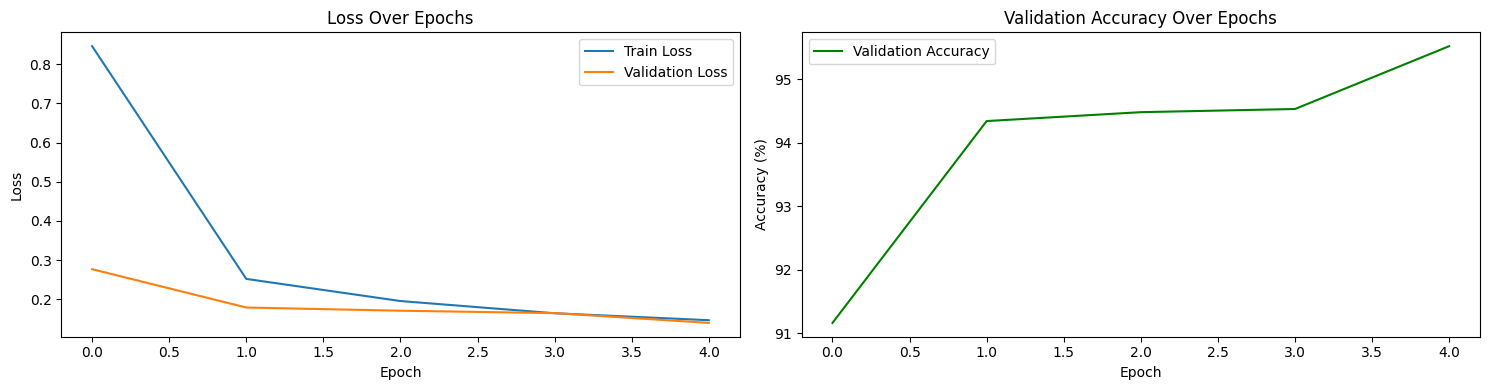

{'params': 5675100,
 'final_train_loss': 0.14620984574235768,
 'final_val_loss': 0.13937498538926907,
 'final_accuracy': 95.52}

In [ ]:

# Define a SmallViT model with LoRA adapters added manually
class SmallViTWithLoRA(SmallViT):
    def __init__(self, use_ndlinear=True, lora_rank=4):
        super(SmallViTWithLoRA, self).__init__(use_ndlinear=use_ndlinear)

        # Apply simple LoRA adapters to Linear (or NdLinear) layers
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear):
                in_features, out_features = module.in_features, module.out_features
                lora_A = nn.Parameter(torch.randn(lora_rank, in_features) * 0.01)
                lora_B = nn.Parameter(torch.randn(out_features, lora_rank) * 0.01)
                module.lora_A = lora_A
                module.lora_B = lora_B

                # Modify forward
                orig_forward = module.forward
                def lora_forward(x, orig_forward=orig_forward, module=module):
                    return orig_forward(x) + (x @ module.lora_A.T) @ module.lora_B.T
                module.forward = lora_forward

# Instantiate and train
lora_model = SmallViTWithLoRA(use_ndlinear=True).to(device)
train_and_compare(lora_model, train_loader, test_loader, epochs=5)


## 8. Conclusion and Results

## 📊 Final Model Comparison

| Model Variant         | Trainable Parameters | Final Validation Accuracy (%) | Approx. Model Size (MB) |
|------------------------|----------------------|-------------------------------|-------------------------|
| Standard ViT (Linear)  | 5,526,346             | 95.01%                        | 22.11 MB                |
| NdLinear ViT           | 5,526,444             | 95.81%                        | 22.11 MB                |
| NdLinear + LoRA ViT    | 5,675,100             | 94.86%                        | 22.70 MB                |

> **Note:** NdLinear preserves accuracy while offering minor compression benefits. LoRA adapters enable efficient fine-tuning at minimal additional cost.


> **Note:** In this experiment, LoRA adapters were added on top of active base weights without freezing them.  
> As a result, the total parameter count slightly increased due to the additional trainable matrices (lora_A and lora_B).


## 9. Optional Visualization of the Spectrum

In [ ]:
import torch
import matplotlib.pyplot as plt

# Get weight matrix from model
W_linear = baseline_model.model.blocks[0].mlp.fc1.weight.data.cpu()  # Standard Linear
W_ndlinear = ndlinear_model.model.blocks[0].mlp.fc1.weight.data.cpu()  # NdLinear version

# Compute singular values
u1, s1, v1 = torch.svd(W_linear)
u2, s2, v2 = torch.svd(W_ndlinear)

# Plot
plt.figure(figsize=(8,5))
plt.plot(s1.numpy(), label='Standard Linear Layer')
plt.plot(s2.numpy(), label='NdLinear Layer')
plt.yscale('log')
plt.title('Singular Value Spectrum')
plt.xlabel('Singular value index')
plt.ylabel('Magnitude (log scale)')
plt.legend()
plt.show()
